In [1]:
import numpy as np
import scipy
import math
import random
import pandas as pd
from matplotlib import animation
import matplotlib as mpl
import seaborn as sns

from matplotlib.animation import FuncAnimation
import os
import time
from skspatial.objects import Sphere
from scipy.stats import uniform
from scipy.integrate import quad
import tqdm as tqdm

from matplotlib import pyplot as plt
from matplotlib import colormaps
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Hernquist Density Profile
The density is given by (Galactic Dynamics, James Binney- pg 70):

$$
    \rho(r) = \frac{\rho_0 Rs^4}{r (r + Rs)^3}.
$$

where $Rs$ is the scale radius.

The mass within a given radius r is:

$$
    M(r) = \int_0^r \rho(r) 4 \pi r^2 dr = \dots = 4  \pi \rho_0 Rs \frac{r^2}{2(1 + \frac{r}{Rs})^2}.
$$
The total mass of the distribution is: 

$$
    M_{tot} = 2 \pi \rho_0 R_s^3 \longrightarrow \rho_0 = \frac{M_{tot}}{2 \pi R_s^3}.
$$

The cumulative distribution function for the radii is:

$$
    P(r) = \frac{M(r)}{M_{tot}} = \frac{r^2}{Rs^2(1 + \frac{r}{Rs})^2} = \frac{r^2}{(Rs + r)^2} 
$$

Inverting this equation, we can find the inverse cumulative distribution function:

$$
    r(P) = \frac{\sqrt{P} Rs}{1 - \sqrt{P}}
$$

The distribution function for $\theta$ and $\phi$ are the ones of a spherically symmetric system:

$$
    P(\phi) = \frac{1}{2 \pi},
$$
$$
    P(\theta) = \frac{1}{2} \left( 1 - \cos\theta \right).
$$

In [2]:
N  = 1000   # numer of particles
M  = 1      # total mass of the system
m  = M/N    # mass of the single particle
Rs = 1      # scale radius
G  = 1      # gravitational constant

rho_0 = M / (4 * np.pi * (Rs)**3)  # initial density

# DISTRIBUTION INITIALIZATION

### Density profile

In [3]:
def Hernquist(r, Rs, rho_0):
    
    return (rho_0 * (Rs**4)) / (r * ((r + Rs)**3))

In [35]:
radii_i  = np.linspace(0.1, 15 * Rs, 100)
rho      = Hernquist(radii_i, Rs, rho_0)

Text(0, 0.5, '$\\rho_H(r)$')

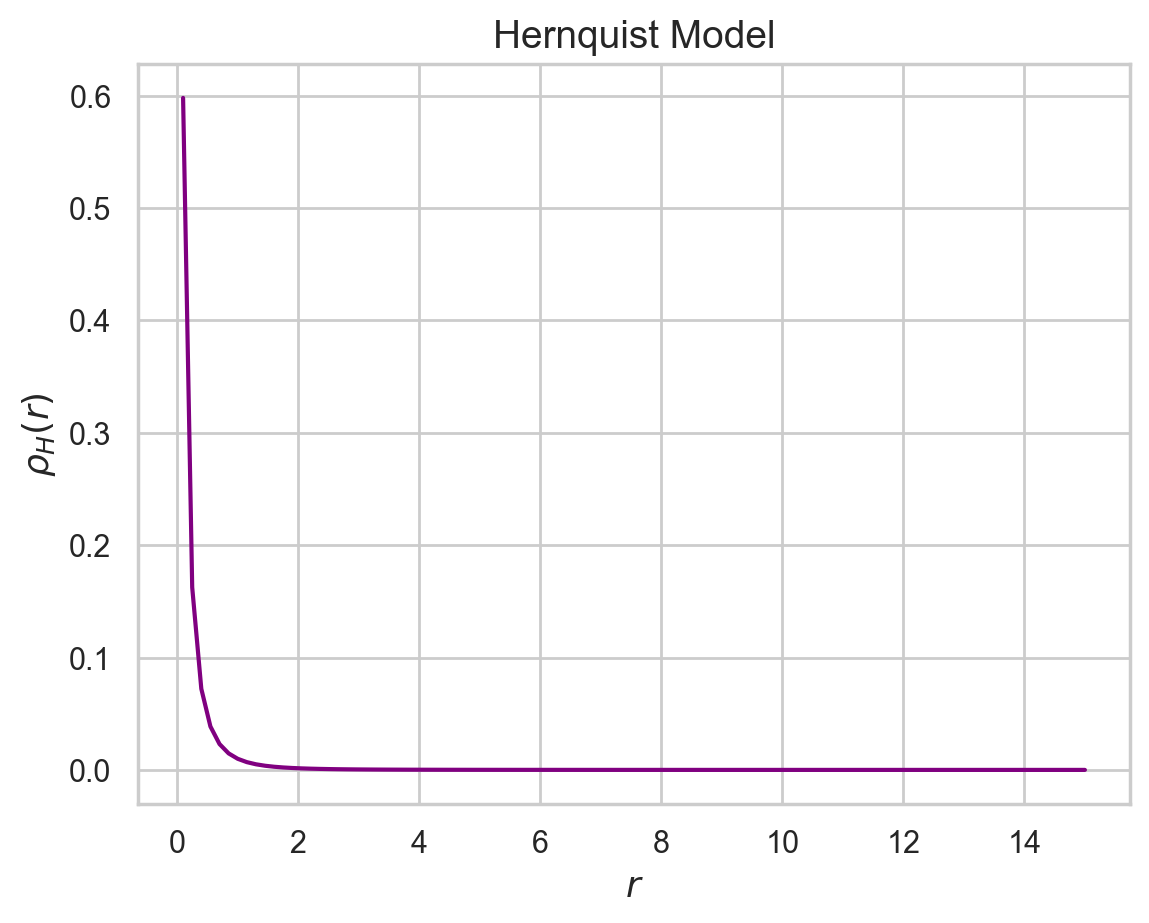

In [36]:
sns.set(style="whitegrid")
plt.plot(radii_i, rho, color='purple')
plt.title('Hernquist Model', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.ylabel(r'$\rho_H(r)$', fontsize=13)

### Positions Sampling

In [37]:
def cumulative(r, Rs): 
    
    '''Cumulative distribution to sample radial positions.'''
    
    return (r**2) / ( (Rs+r )**2)


def inv_cumulative(Rs, N):
    
    P = np.random.uniform(0, max(Pr_i), size = N)
    
    return (np.sqrt(P) * Rs) / (1 - np.sqrt(P))

In [38]:
Pr_i   = cumulative(radii_i, Rs)
np.max(Pr_i)

0.87890625

C:\Users\guide\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\guide\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\guide\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\guide\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

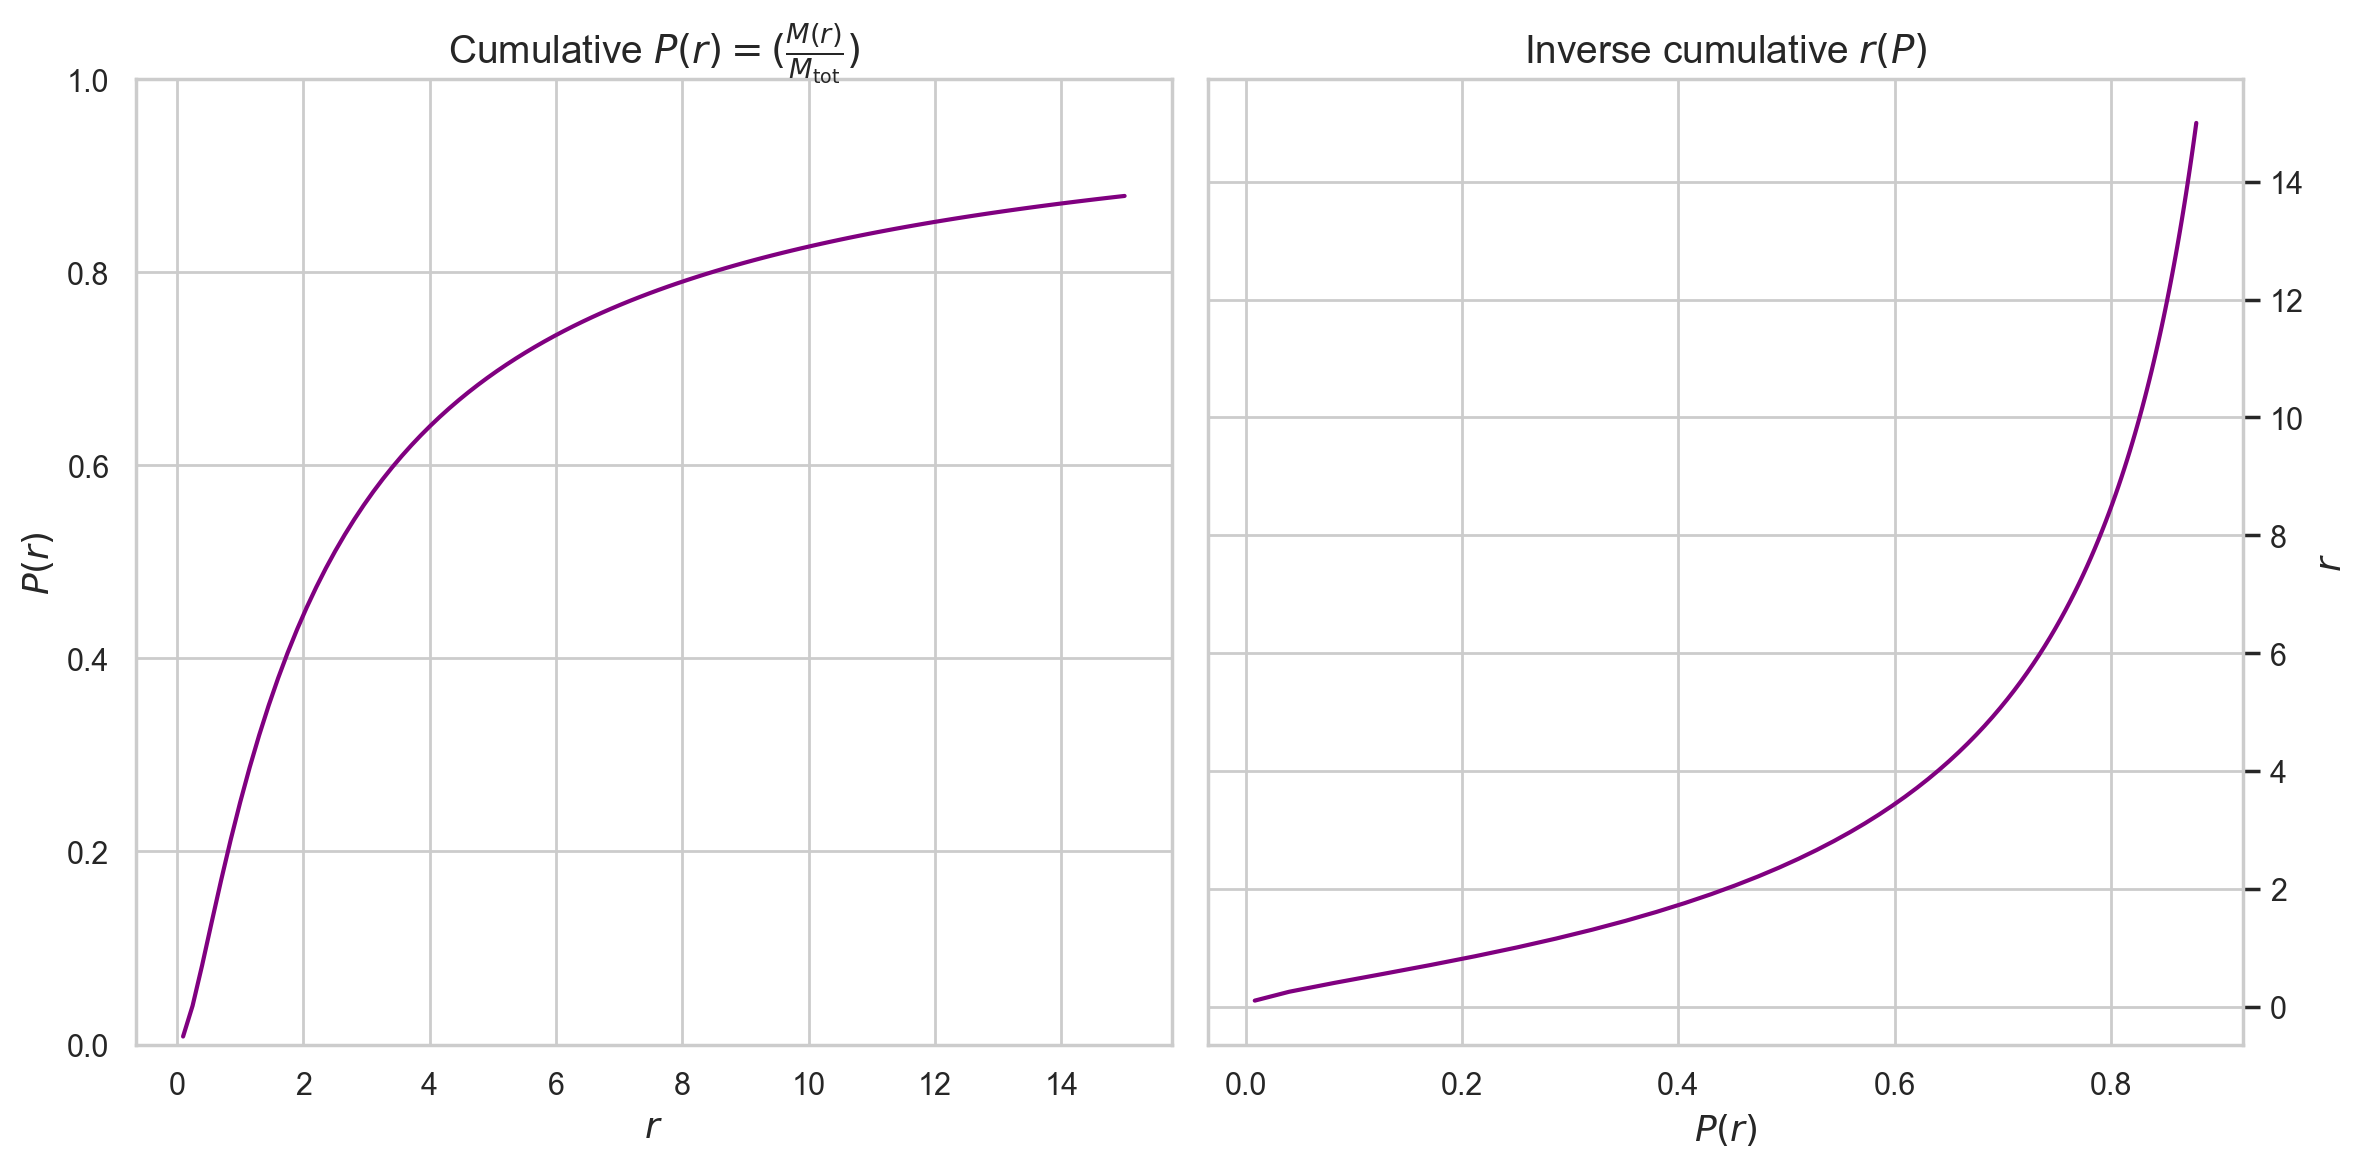

In [39]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 6))

sns.lineplot(x = radii_i, y = Pr_i, ax=ax[0], color='purple')
ax[0].set_title(r'Cumulative $P(r)=(\frac{M(r)}{M_{\mathrm{tot}}})$', fontsize=14)
ax[0].set_xlabel(r'$r$', fontsize=13)
ax[0].set_ylabel(r'$P(r)$', fontsize=13)
ax[0].set_ylim(0, 1)

sns.lineplot(x = Pr_i, y = radii_i, ax=ax[1], color='purple')
ax[1].set_title(r'Inverse cumulative $r(P)$', fontsize=14)
ax[1].set_xlabel(r'$P(r)$', fontsize=13)
ax[1].set_ylabel(r'$r$', fontsize=13)

# Adjust spacing between subplots
#plt.subplots_adjust(wspace=0.5)

# Common y-axis label
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

plt.show()

In [40]:
radii   = inv_cumulative(Rs, N)

P_theta = np.random.uniform(0, 1, N)
theta   = np.arccos(1 - 2 * P_theta)

P_phi   = np.random.uniform(0, 1, N)
phi     = P_phi * 2 * np.pi

In [41]:
def calculate_radius(r, percentage):
    ''' Calcolo del raggio entro il quale sta una certa percentuale di particelle'''
    
    sorted_r = np.sort(r)
    
    index = int(len(sorted_r) * percentage / 100)
    radius = sorted_r[index]
    
    return radius


percentage = 75  # percentuale delle particelle da considerare

radius = calculate_radius(radii, percentage)
print(f"Raggio entro il quale si trova il {percentage}% delle particelle: {radius}")
print(radius/Rs)

Raggio entro il quale si trova il 75% delle particelle: 3.95687478280879
3.95687478280879


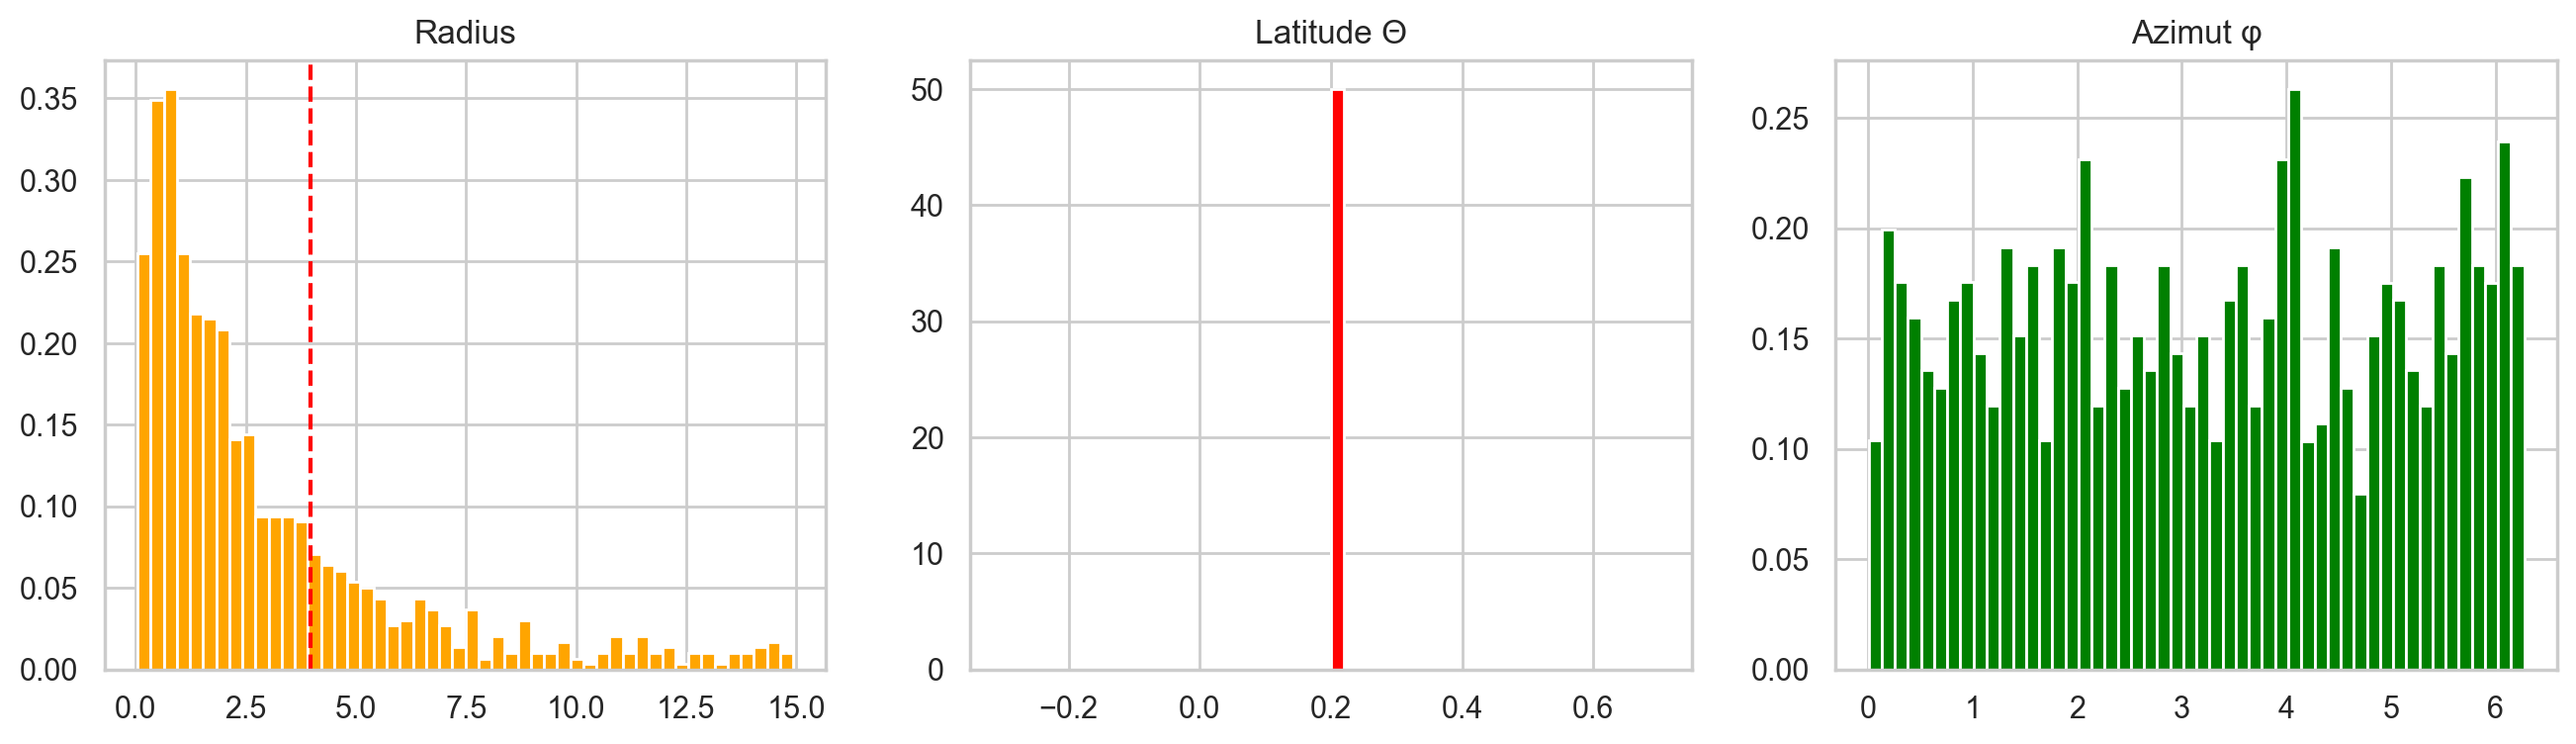

In [63]:
fig, axs = plt.subplots(1,3,figsize=(16,4))

axs[0].hist(radii, bins=50, density=True, color='orange')
axs[0].set_title('Radius')
axs[0].axvline(x = radius * Rs, linestyle='--', color='red', label = r'$4Rs (75% of particles)$')
#axs[0].set_xlabel('0 ≤ a ≤ 1')
#axs[0].legend()

# Plot the histogram of theta on the second column
axs[1].hist(theta, bins=50, density=True, color='red')
axs[1].set_title('Latitude Θ')
#axs[1].set_xlabel('Radians')

# Plot the histogram of phi on the third column
axs[2].hist(phi, bins=50, density=True, color='green')
axs[2].set_title('Azimut φ')
#axs[2].set_xlabel('Radians')

plt.show()

In [43]:
# cartesian coords
x = radii * np.sin(theta) * np.cos(phi)
y = radii * np.sin(theta) * np.sin(phi)
z = radii * np.cos(theta)

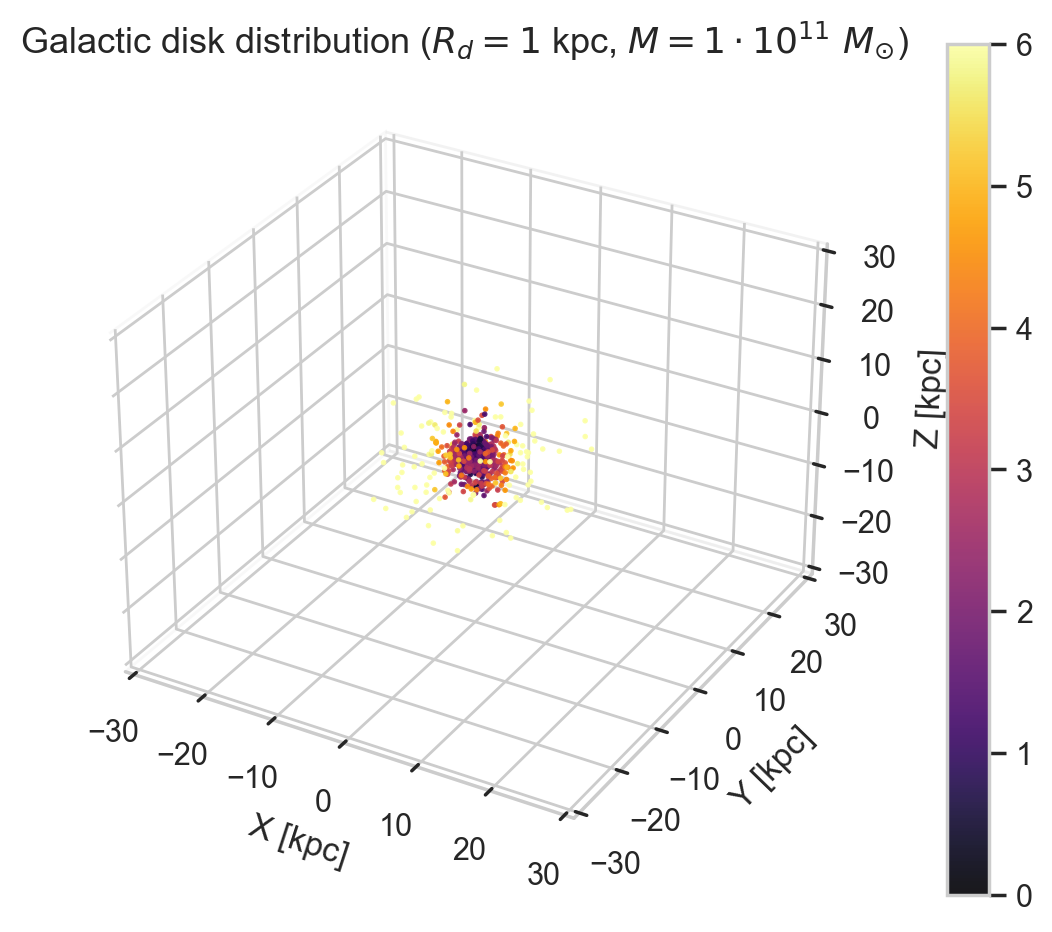

In [44]:
fig = plt.figure(figsize=(10, 5), tight_layout=True)

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
image=ax.scatter(x, y, z, c = np.sqrt(x**2+y**2), alpha=0.9, s=1, cmap='inferno', clim=(0, 6 * Rs))
ax.set_xlabel('X [kpc]', fontsize=12)
ax.set_ylabel('Y [kpc]', fontsize=12)
ax.set_zlabel('Z [kpc]', fontsize=12)
ax.set_title(rf'Galactic disk distribution ($R_d={Rs}$ kpc, $M = {M} \cdot 10^{{11}} \ M_{{\odot}}$)', fontsize=13)
ax.set_xlim(-30 * Rs, 30 * Rs)
ax.set_ylim(-30 * Rs, 30 * Rs)
ax.set_zlim(-30 * Rs, 30 * Rs)
plt.colorbar(image, fraction=0.046, pad=0.09)
plt.tight_layout()

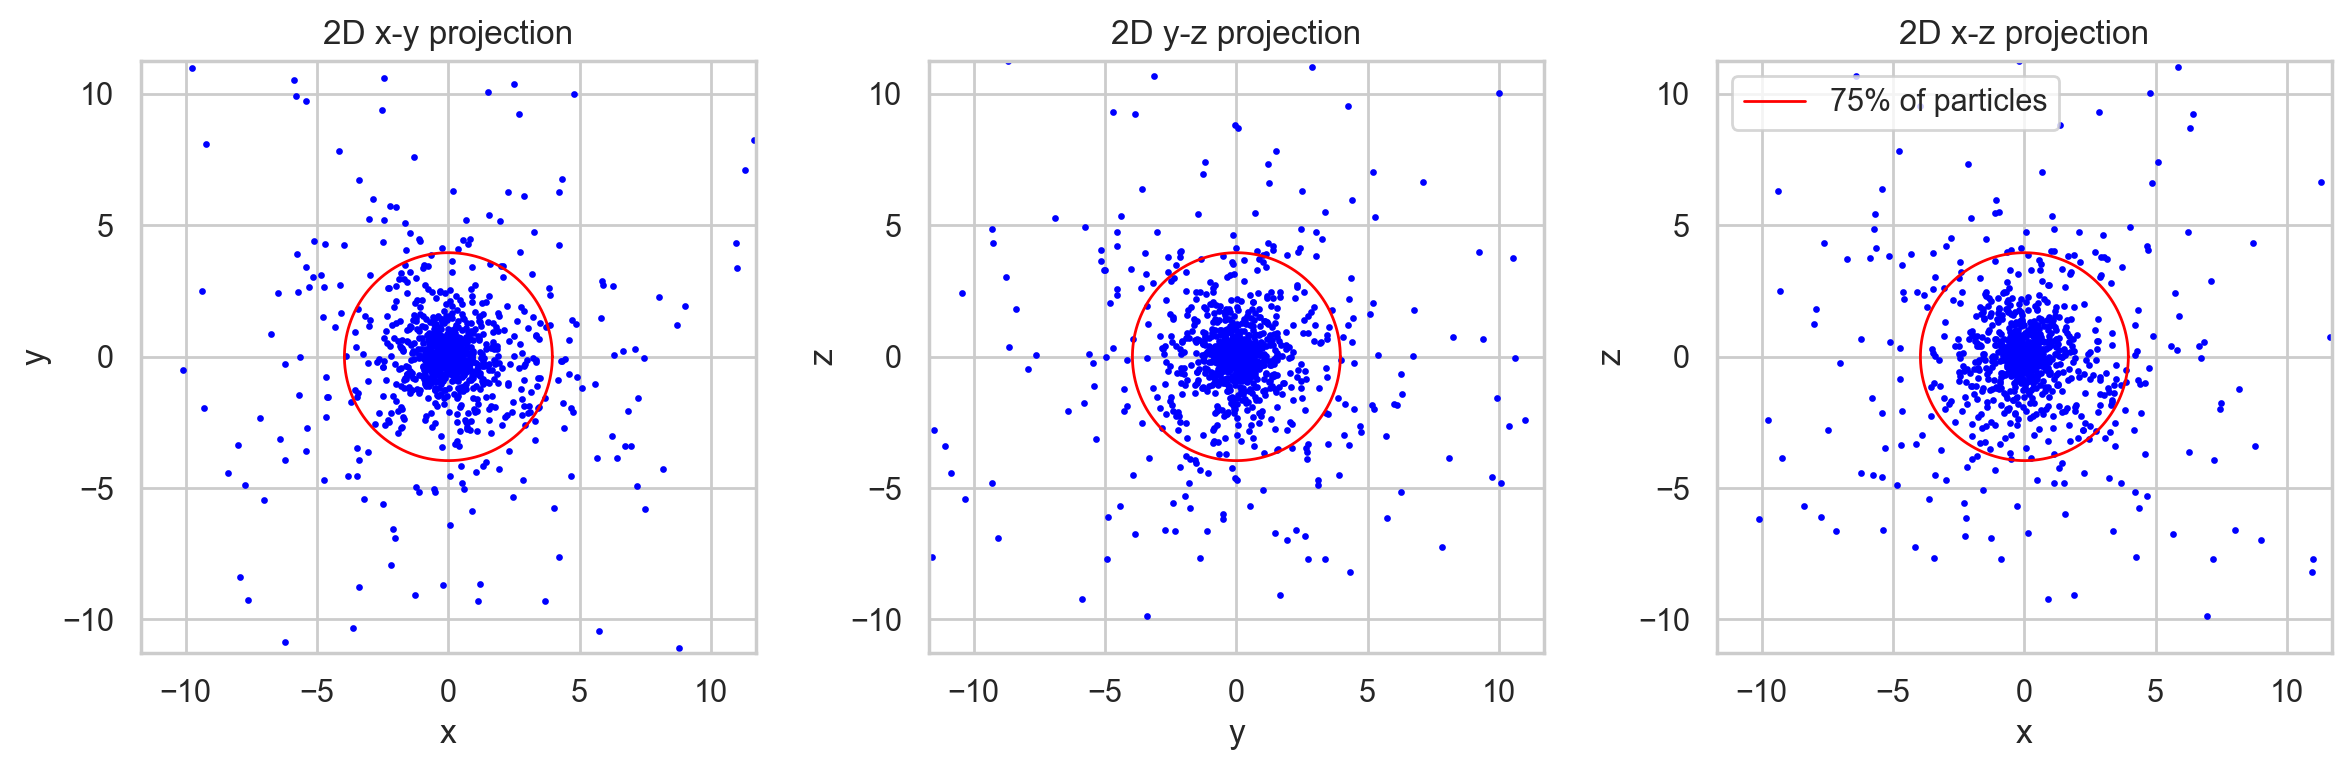

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

theta_lim = np.linspace(0, 2 * np.pi, 150)
a = radius * Rs * np.cos( theta_lim )
c = radius * Rs * np.sin( theta_lim )

axes[0].scatter(x, y, c='blue', s=2)
axes[0].plot(a, c, c='red', linewidth=1, label=r'75% of particles')
axes[0].axis('equal')
axes[0].set_xlim(-10, 10)
axes[0].set_ylim(-10, 10)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('2D x-y projection')

# Projection on y-z plane
axes[1].scatter(y, z, c='blue', s=2)
axes[1].plot(a, c, c='red', linewidth=1, label=r'75% of particles')
axes[1].axis('equal')
axes[1].set_xlim(-10, 10)
axes[1].set_ylim(-10, 10)
axes[1].set_xlabel('y')
axes[1].set_ylabel('z')
axes[1].set_title('2D y-z projection')


# Projection on x-z plane
axes[2].scatter(x, z, c='blue', s=2)
axes[2].plot(a, c, c='red', linewidth=1, label=r'75% of particles')
axes[2].axis('equal')
axes[2].set_xlim(-10, 10)
axes[2].set_ylim(-10, 10)
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
axes[2].set_title('2D x-z projection')

plt.legend()
plt.tight_layout()
plt.show()

### Potential

The potential is:

$$
    \Phi(r) =-  4 \pi G \rho_0 Rs^2 \frac{1}{2(1+ \frac{r}{Rs})}
$$

In [46]:
def H_potential(radii, Rs, rho_0):
    return - 4 * math.pi * G * rho_0 * Rs**2 * (1 / (2 * (1 + radii/Rs)))

In [47]:
sorted_radii = np.sort(radii)
Psi          = H_potential(sorted_radii, Rs, rho_0)

Text(0, 0.5, '$\\Phi_J(r)$')

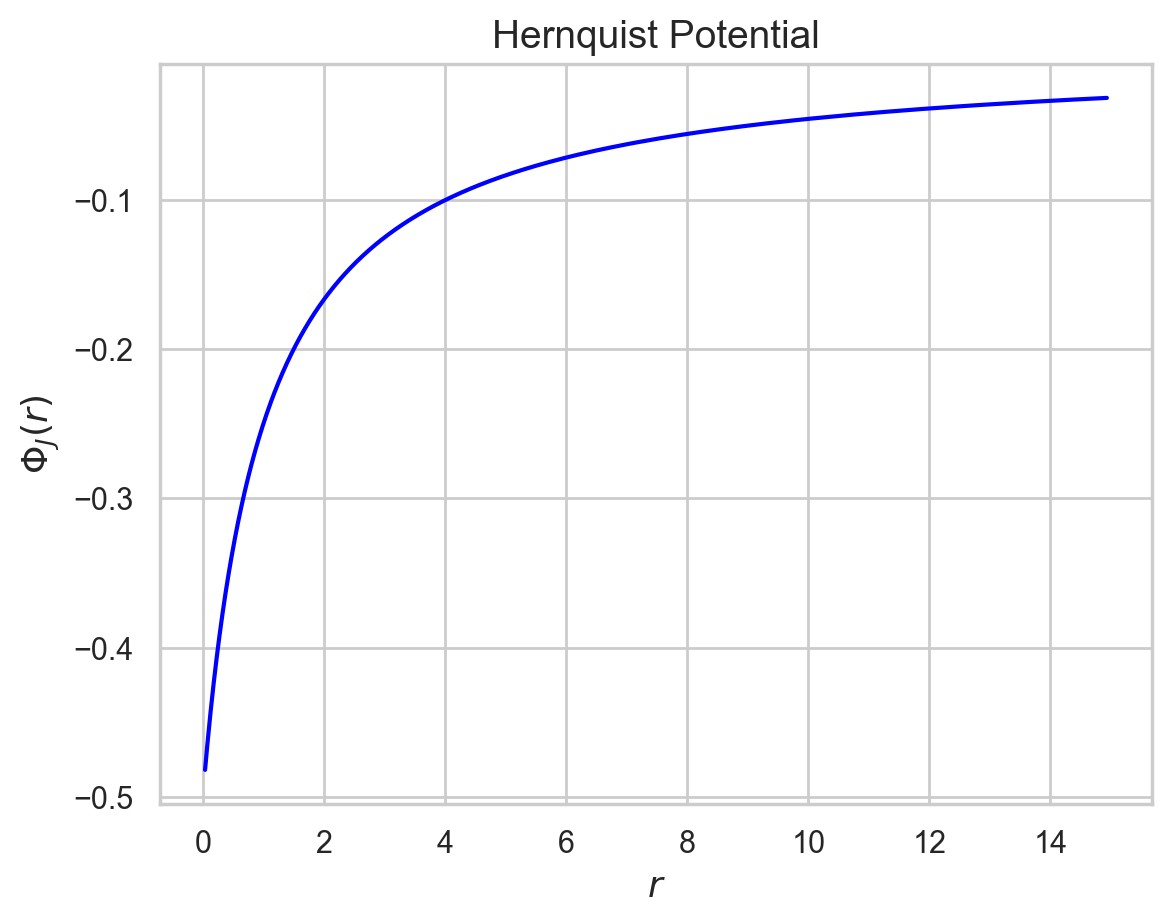

In [48]:
sns.set(style="whitegrid")

plt.plot(sorted_radii, Psi, color='blue')
plt.title('Hernquist Potential', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.ylabel(r'$\Phi_J(r)$', fontsize=13)

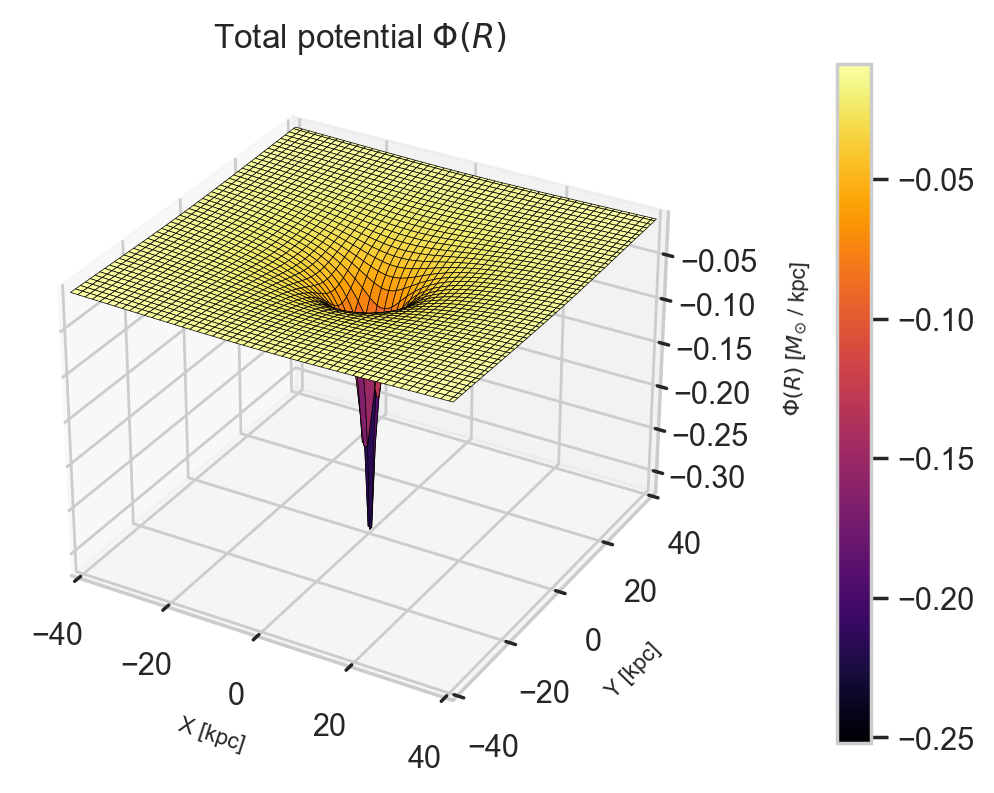

In [49]:
x_pot = np.linspace(-40 * Rs, 40 * Rs, 100)
y_pot = np.linspace(-40 * Rs, 40 * Rs, 100)

X, Y = np.meshgrid(x_pot, y_pot)
Psi_2d = H_potential(np.sqrt(X**2+Y**2), Rs, rho_0)

fig = plt.figure(figsize=(8, 4), tight_layout=True)
ax = fig.add_subplot(1, 1, 1, projection='3d')
image=ax.plot_surface(X, Y, Psi_2d, cmap='inferno', edgecolor='black', lw=0.25)
ax.set_xlabel('X [kpc]', fontsize=8)
ax.set_ylabel('Y [kpc]', fontsize=8)
ax.set_zlabel('\n\n $\Phi(R)$ [$M_{\odot}$ / kpc]', fontsize=8)
ax.set_title(r'Total potential $\Phi(R)$', fontsize=12)
ax.set_xlim(-40 * Rs, 40 * Rs)
ax.set_ylim(-40 * Rs, 40 * Rs)
ax.set_zlim(np.min(Psi_2d), np.max(Psi_2d))
#ax.view_init(35, -75)
plt.tight_layout()
plt.colorbar(image, fraction=0.046, pad=0.09)
#plt.savefig('Total-pot.pdf', bbox_inches='tight');
plt.show()

## Distribution Function

Page 302
$$
    f_H(\epsilon)=\frac{1}{\sqrt{2}(2 \pi)^3 (GM R_s)^{\frac{3}{2} }  } \frac{\sqrt{\epsilon}}{(1- \epsilon)^2} \left[ (1-2\epsilon) (8\epsilon ^2 - 8 \epsilon -3) + \frac{3 sin^{-1} \sqrt{\epsilon}}{\sqrt{\epsilon (1 - \epsilon)}}    \right]
$$
where $\epsilon = -\frac{E R_s}{GM}$

In [50]:
def df_H(E, Rs, G, M):

    epsilon = (E*Rs)/(G*M)
    term1 = 1 / ( np.sqrt(2) * ((2 * np.pi)**3) * ((G * M * Rs)**(3/2)) )
    term2 = np.sqrt(epsilon) / ((1 - epsilon)**2)
    term3 = (1 - 2 * epsilon) * ((8 * (epsilon**2)) - (8 * epsilon) - 3)
    term4 = (3 * (np.arcsin(np.sqrt(epsilon)) )  ) / (np.sqrt(epsilon * (1 - epsilon)))
    result = term1 * term2 * (term3 + term4)
    
    return result
    

(-0.1, 1.5)

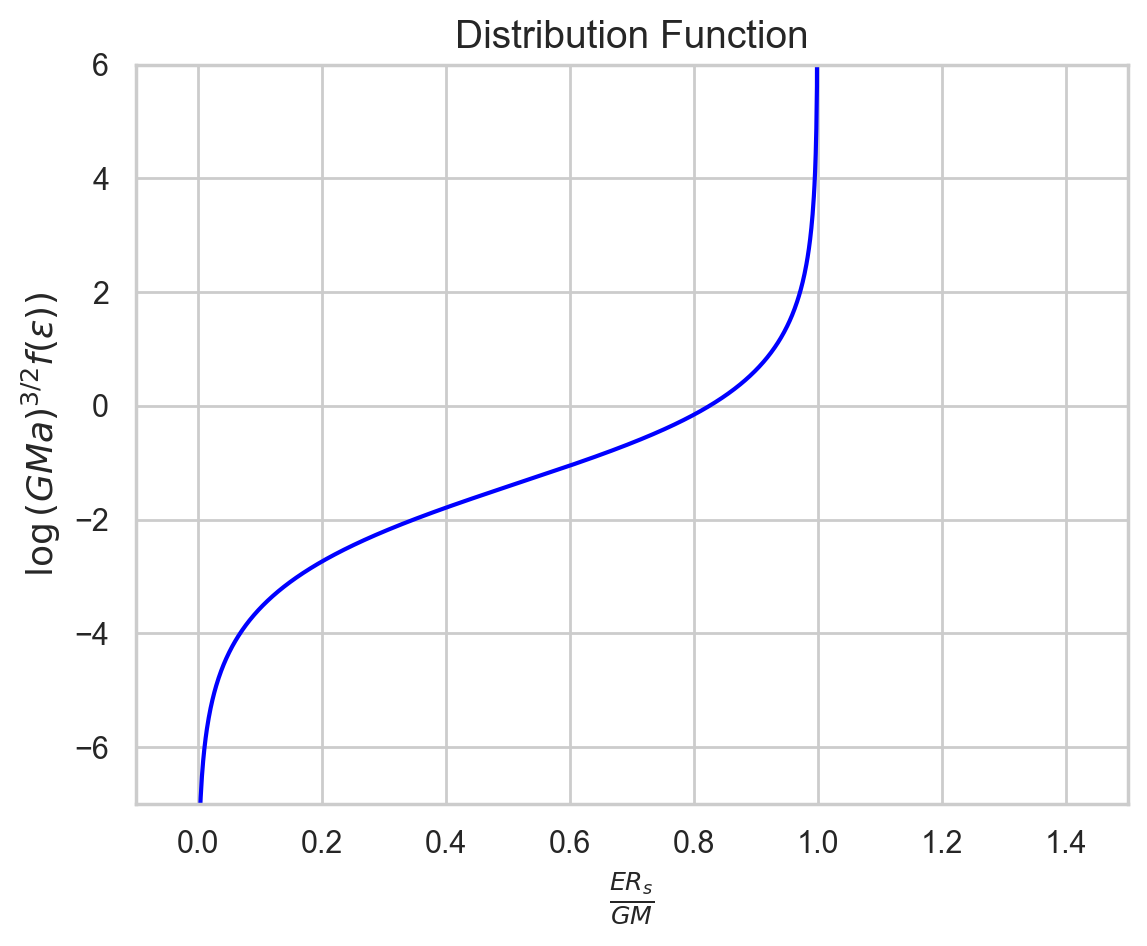

In [51]:
asse_x = np.linspace(0.00001, 0.99999, N) # come sul libro

E   = asse_x * (G*M/Rs)

df  = df_H(E, Rs, G, M)

asse_y = np.log10(((G*M*Rs)**(3/2)) * df)

sns.set(style="whitegrid")


plt.plot(E, asse_y, color='blue')
plt.title(r'Distribution Function', fontsize=14)
plt.xlabel(r'$\frac{ER_s}{GM}$', fontsize=13)
plt.ylabel(r'$\log{(GMa)^{3/2} f(\varepsilon))}$', fontsize=13)

plt.ylim(-7,6)
plt.xlim(-0.1,1.5)

## MC rejection method

In [52]:
asse_x  = np.linspace(0.1, 0.99, N)
E       = asse_x * (G*M/Rs)
df      = df_H(E, Rs, G, M)
asse_y  = ((G*M*Rs)**(3/2)) * df

g = np.ones(int(N))*np.max(df)

q_sample = []
f_sample = []

for i in range(N):
    y_rand = np.max(g) + 1
    rand = np.random.uniform(0,1)
    while y_rand > df_H(rand, Rs, G, M):
        rand = np.random.uniform(0.1,0.99)
        y_rand = np.random.uniform(0,np.max(g))

    q_sample.append(rand)
    f_sample.append(y_rand)

q_sample = np.array(q_sample)
f_sample = np.array(f_sample)

(0.647230849255344, 1.01)

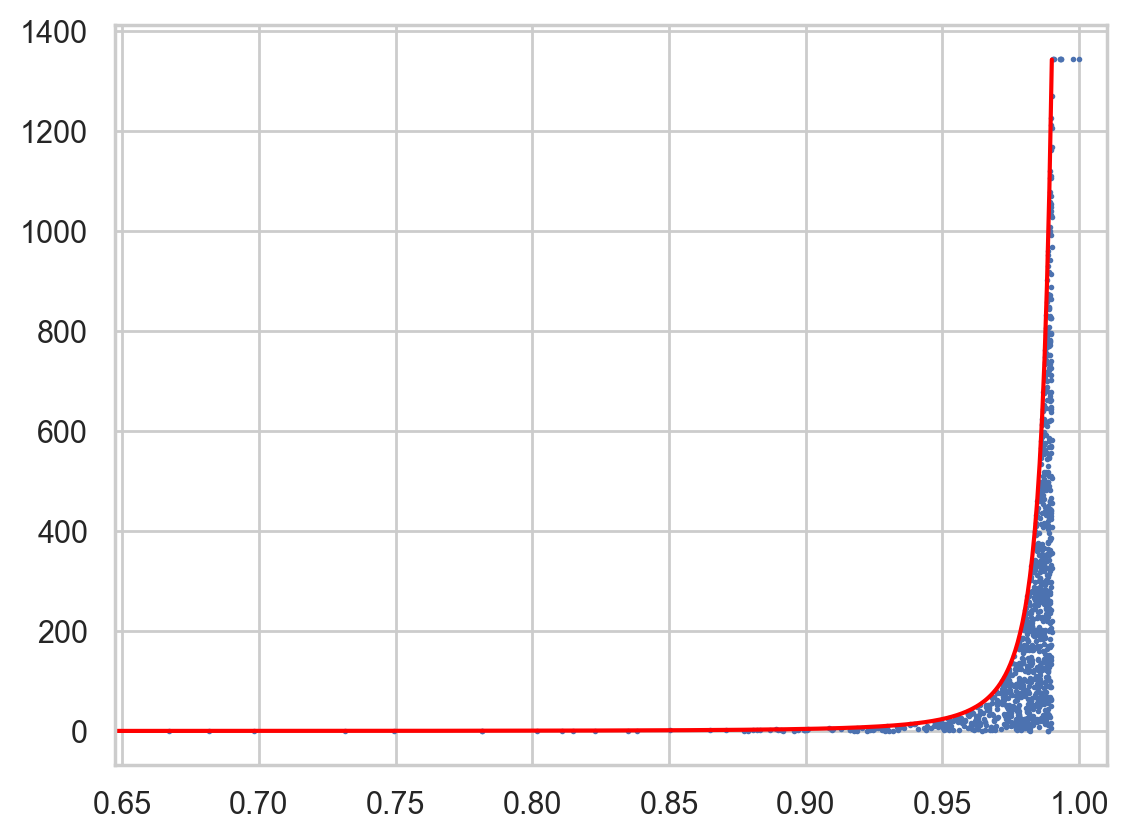

In [53]:
#plt.hist(q_sample,100, density=True)
plt.scatter(q_sample, f_sample, label='MC accept-reject', s=1)
plt.plot(asse_x,df, color='red');
#plt.ylim(0,75)
plt.xlim(np.min(q_sample)-0.02,1.01)

### Velocities

In [54]:
v = q_sample * np.sqrt(-2 * Psi)

v_theta_cdf = np.random.uniform(0,1,N)
v_theta = np.arccos(1 - 2 * v_theta_cdf)

v_phi = np.random.uniform(0, 2 * np.pi, size=N) 

In [55]:
v_x = v * np.cos(v_phi) * np.sin(v_theta)
v_y = v * np.sin(v_phi) * np.sin(v_theta)
v_z = v * np.cos(v_theta)

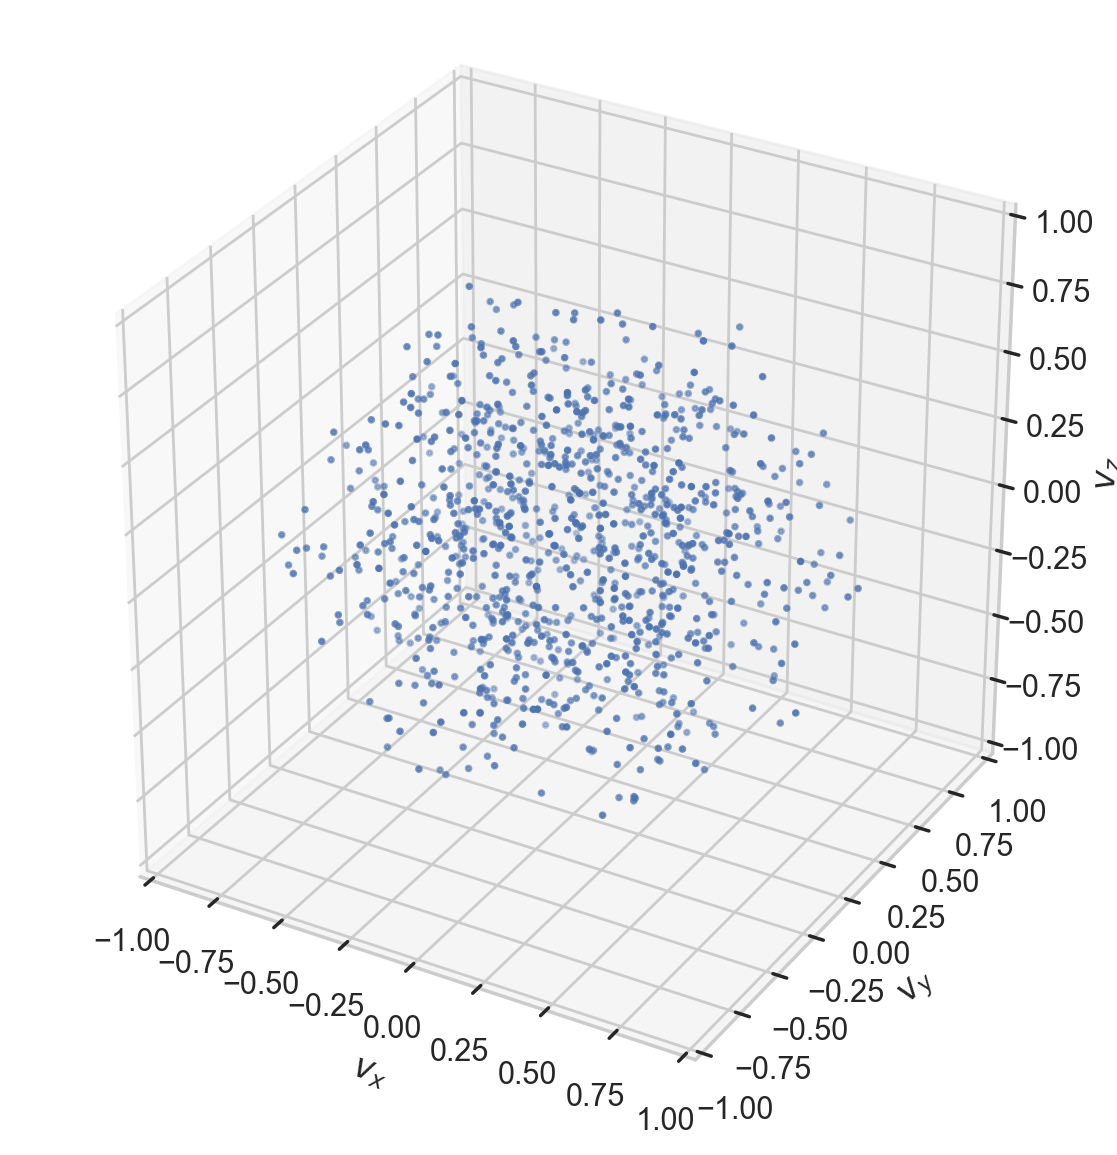

In [56]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(projection='3d')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.scatter(v_x, v_y, v_z, c = 'b', s=3)
ax.set_aspect('equal')
ax.set_xlabel(r'$v_x$')
ax.set_ylabel(r'$v_y$')
ax.set_zlabel(r'$v_z$')
plt.show();

## Initial conditions

In [57]:
# creating the input file
m_arr = m * np.ones(N)
dim = 3


with open ('in_H.txt', 'w+') as f:
    f.write(str(N) + '\n')
    f.write(f'{dim}' + '\n')
    f.write('0' + '\n')
    for m_i in m_arr:
        f.write(f'{m_i}' + '\n')
    for i in range(N):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    for j in range(N):
        f.write(f'{v_x[j]} {v_y[j]} {v_z[j]}' + '\n')

In [58]:
rho0 = 3*M/(4*np.pi*Rs**3) * 1/((1+(radii**2/Rs**2))**(5/2))
#print("Density: ",rho0)

T_dyn = (3*np.pi/(16*G*rho_0))**(1/2)
print("Dynamical Time: ", T_dyn)

V = 4/3 * np.pi * Rs**3
epsilon = round(1/10 * (V/N)**(1/3), 4)
print("Epsilon: ", epsilon)

T_sim = np.round(10 * T_dyn)
print("Simulation time: ", T_sim)

dt = 1/20
theta = 0.2
t_out = dt

Dynamical Time:  2.7206990463513265
Epsilon:  0.0161
Simulation time:  27.0


In [59]:
print('./treecode in=in_H.txt  dtime='+ str(dt) +' theta='+str(theta)+ ' tstop='+str(T_sim) +' dtout='+str(t_out)+  ' out=out_H.txt >logout_H.txt')


./treecode in=in_H.txt  dtime=0.05 theta=0.2 tstop=27.0 dtout=0.05 out=out_H.txt >logout_H.txt


# ANALYSIS

In [60]:
lines = pd.read_csv('out_H.txt', names = list(range(3)), sep = '\s+')
N_particles = N
s = N*3+3

t_s  = np.array([lines.iloc[2::s,0].copy().dropna()]).flatten()
m_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(3, N+3)])
x_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(N+3, 2*N+3)])
y_s  = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(N+3, 2*N+3)])
z_s  = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(N+3, 2*N+3)])
vx_s = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(2*N+3, 3*N+3)])
vy_s = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(2*N+3, 3*N+3)])
vz_s = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(2*N+3, 3*N+3)])
#calcolo raggi
r_s = np.sqrt(x_s**2 + y_s**2 + z_s**2)

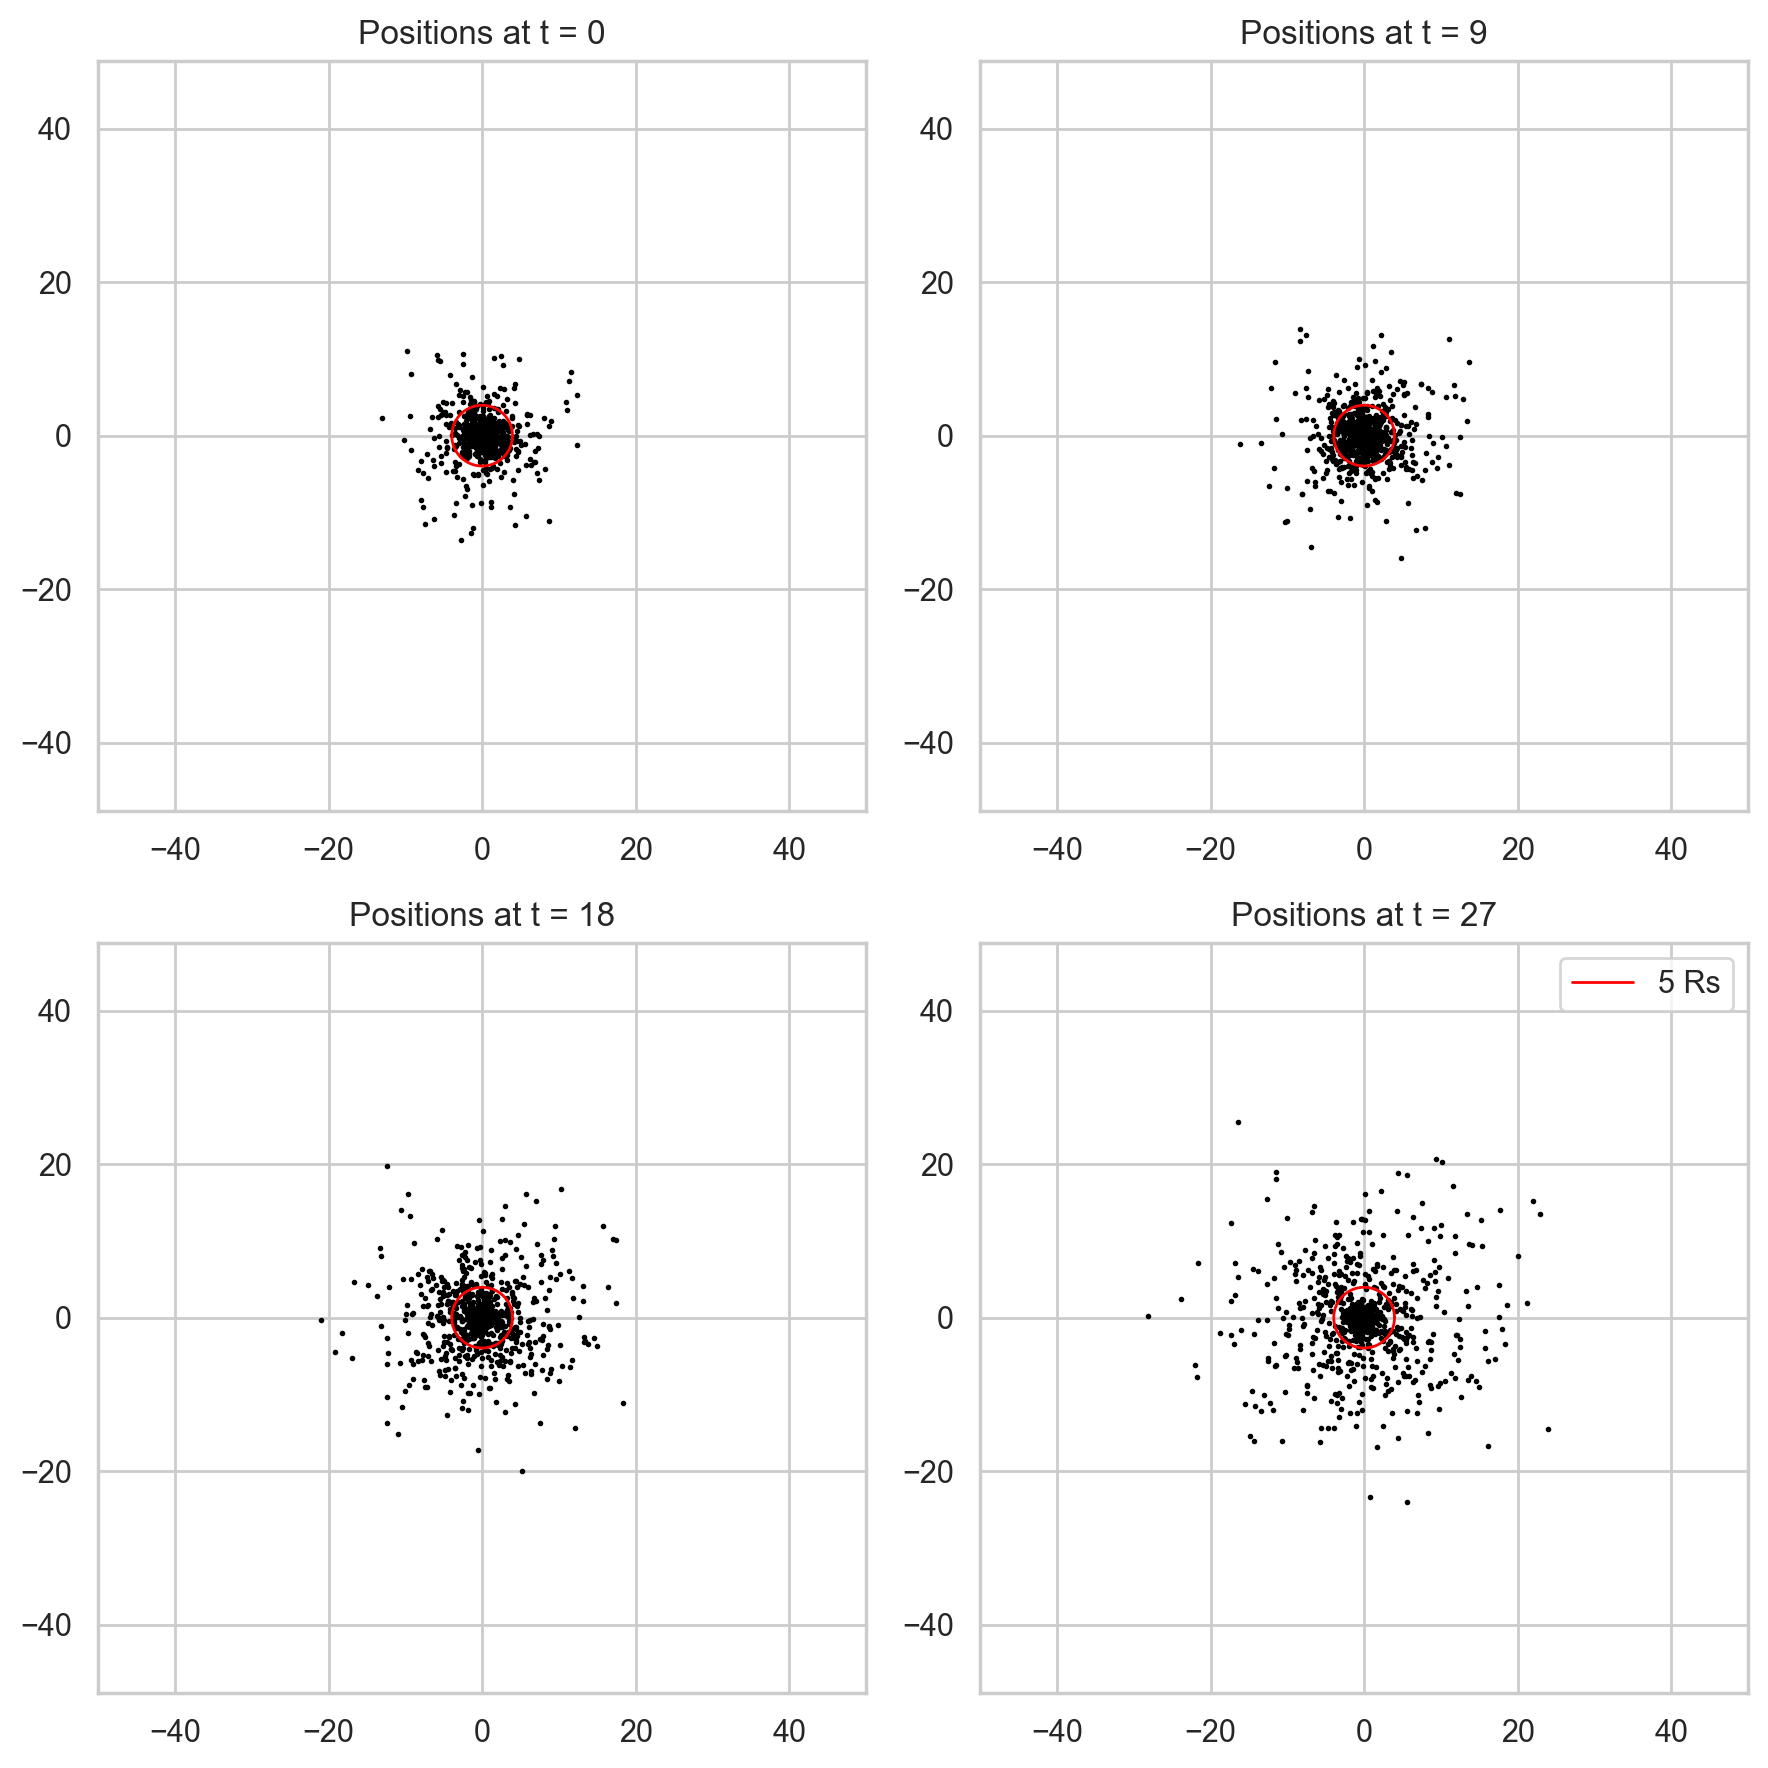

In [61]:
t0 = 0
t1 = int(np.round(len(t_s) * 1 / 3))
t2 = int(np.round(len(t_s) * 2 / 3))
t3 = -1

# Set Seaborn style
sns.set(style="whitegrid")

fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(9, 9)) 

# Plot 1
ax[0][0].scatter(x_s[:, t0], y_s[:, t0], c='black', alpha=1, s=1)#, label='Particles at t=0')

ax[0][0].set_title(f'Positions at t = {int(np.round(t_s[t0]))}')
ax[0][0].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[0][0].axis('equal')
#ax[0][0].legend(fontsize='large')
ax[0][0].set_xlim(-50, 50)
ax[0][0].set_ylim(-50, 50)


# Plot 2
ax[0][1].scatter(x_s[:, t1], y_s[:, t1], c='black', alpha=1, s=1)#, label='Particles at t1')

ax[0][1].set_title(f'Positions at t = {int(np.round(t_s[t1]))}')
ax[0][1].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[0][1].axis('equal')
#ax[0][1].legend(fontsize='large')
ax[0][1].set_xlim(-50, 50)
ax[0][1].set_ylim(-50, 50)


# Plot 3
ax[1][0].scatter(x_s[:, t2], y_s[:, t2], c='black', alpha=1, s=1)#, label='Particles at t2')

ax[1][0].set_title(f'Positions at t = {int(np.round(t_s[t2]))}')
ax[1][0].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[1][0].axis('equal')
#ax[1][0].legend(fontsize='large')
ax[1][0].set_xlim(-50, 50)
ax[1][0].set_ylim(-50, 50)

# Plot 4
ax[1][1].scatter(x_s[:, t3], y_s[:, t3], color='black', alpha=1, s=1)#, label='Particles at t=T_sim')
ax[1][1].plot(a, c, c='red', linewidth=1, label=r'5 Rs')
ax[1][1].set_title(f'Positions at t = {int(np.round(t_s[t3]))}')
ax[1][1].axis('equal')
ax[1][1].legend()
ax[1][1].set_xlim(-50, 50)
ax[1][1].set_ylim(-50, 50)

plt.show()

  0%|          | 0/541 [00:00<?, ?it/s]

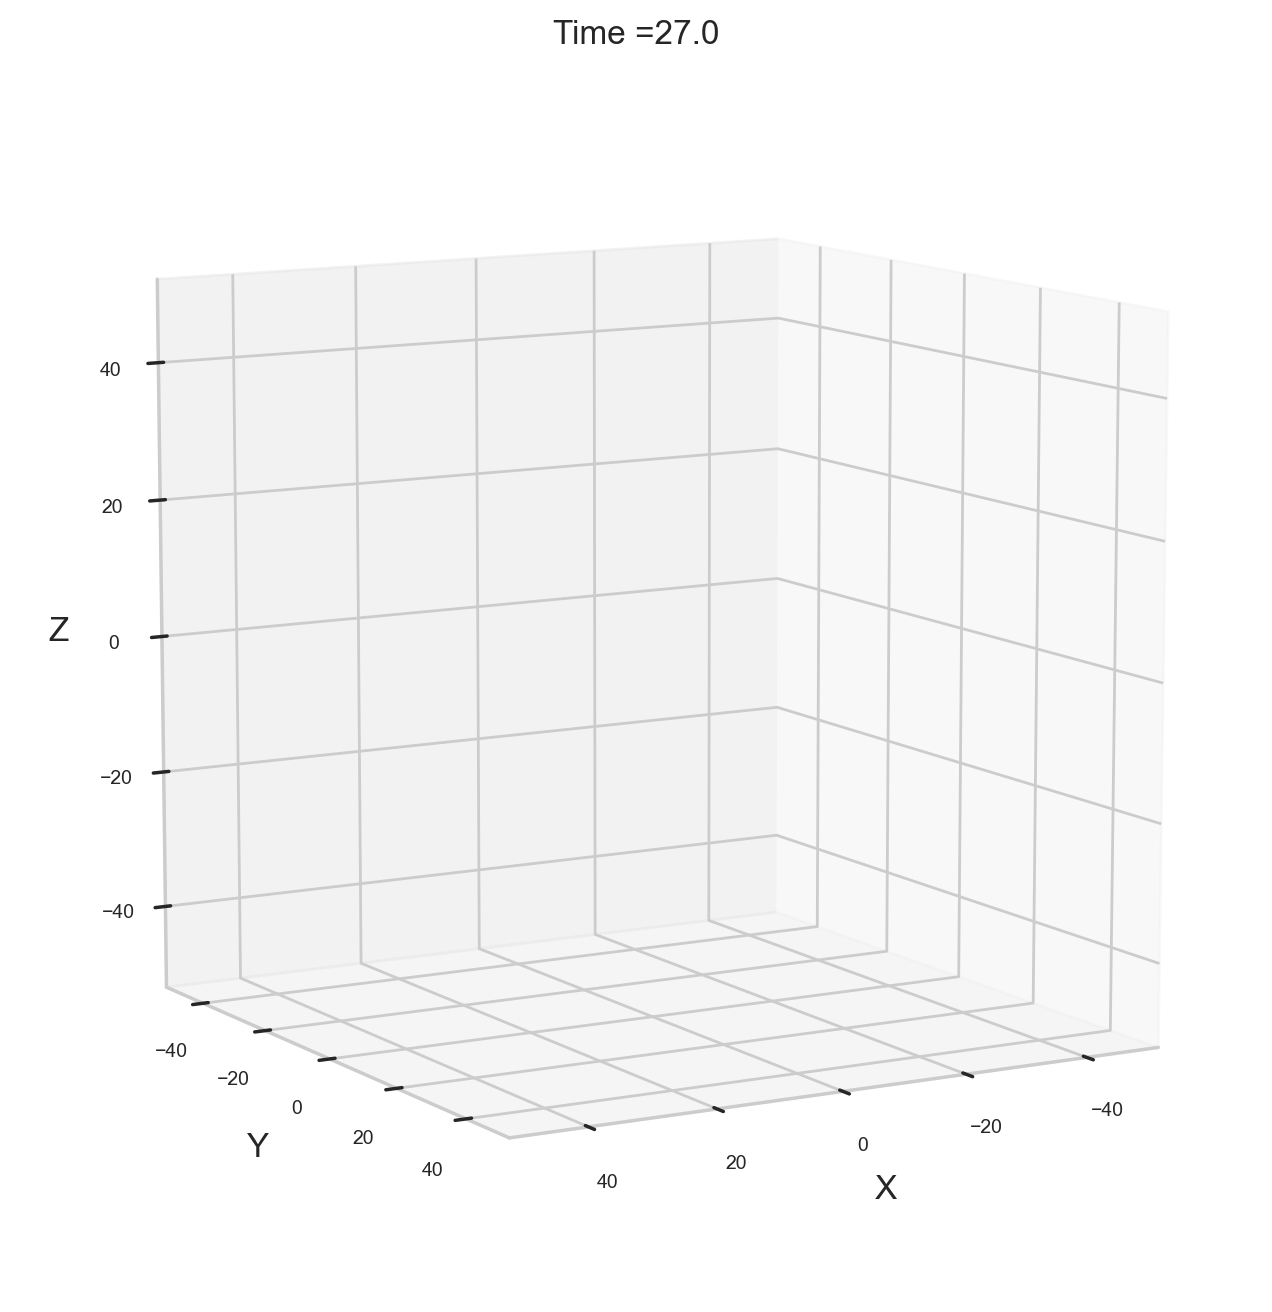

In [62]:
# ANIMATION


from tqdm.notebook import tqdm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

#plot------------------------------------------------------------------------------

fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(projection='3d')
ax.set_aspect('equal')

ax.view_init(elev=10, azim=60)
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)
ax.set_zlim(-50,50)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='z', labelsize=7)


#animation--------------------------------------------------------------------------------
scatters, = ax.plot([], [], [], 'o', markersize='0.8', alpha=0.3)


def init():
    scatters.set_data([], [])
    scatters.set_3d_properties([])
    return scatters,

def animate_time(i): 
    scatters.set_data(x_s[:,i], y_s[:,i])
    scatters.set_3d_properties(z_s[:,i])
    ax.set_title('Time =' + str(np.round((np.array(t_s))[i])))
        
    return scatters,


num_frames = len(t_s)/2
animazione = FuncAnimation(fig, animate_time, frames=tqdm(range(len(t_s))), interval=100, init_func=init) #frames = num_frames interval =100

theta_ = np.linspace(0,2*np.pi,1000)

writergif = animation.PillowWriter(fps=30)
#writer = animation.PillowWriter(fps=30)
#animazione.save('plummer_sphere.gif', writer = 'ffmpeg', dpi=30)
animazione.save(f'Hernquist.gif', writer = writergif)
#plt.show()

plt.rcParams['animation.html'] = 'html5'


### Lagrangian radius

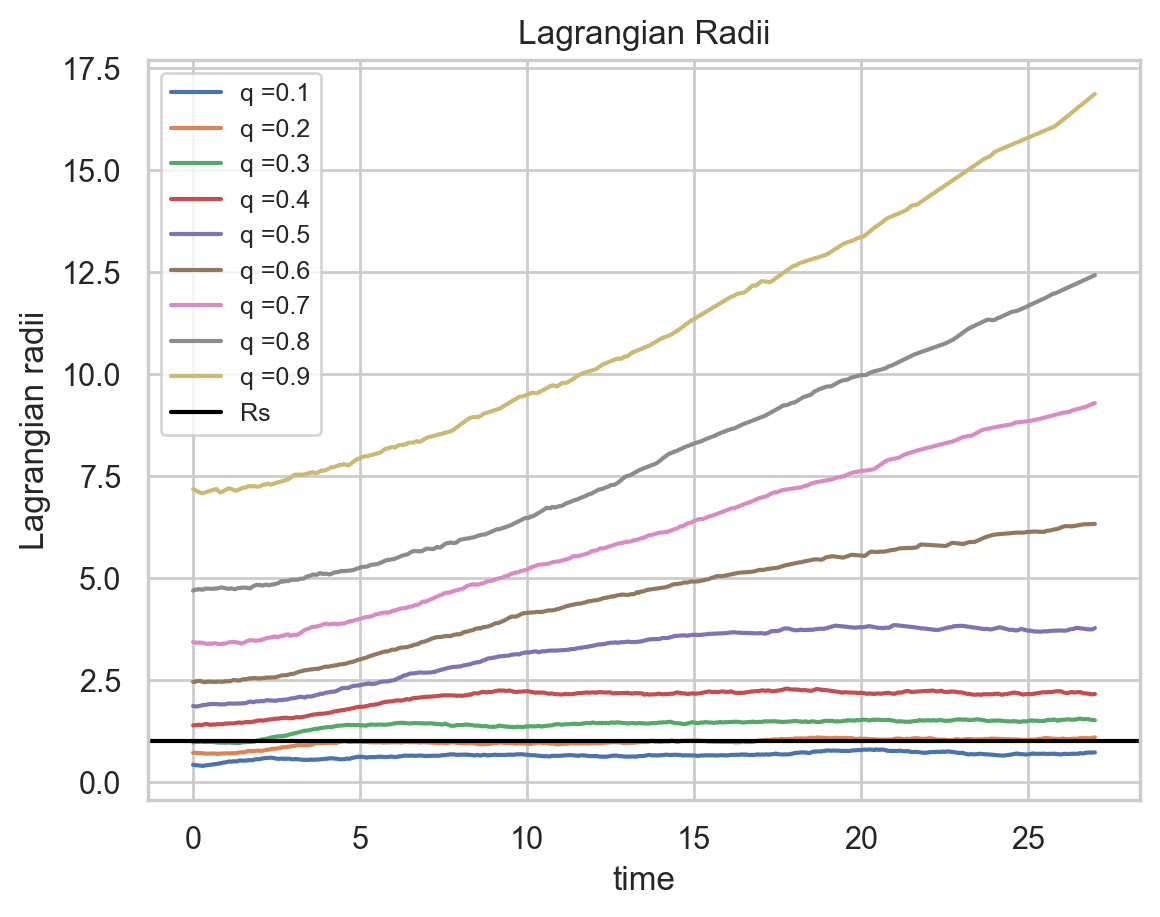

In [64]:
def Lagrangian_Radius(radius_array, quantile):
    
    L_radii = []
    
    # cycle over N_time_output
    for i in range(len(radius_array[0])):
        
        radii_sorted = np.sort(radius_array[:,i])
        mask = radii_sorted < np.quantile(radii_sorted, quantile)
        L_radii.append(np.max(radii_sorted[mask]))
        
    return np.array(L_radii)

##############################################################################
quantiles = np.linspace(0.1, 0.9, 9)

for q in quantiles:
    
    L = Lagrangian_Radius(r_s, round(q,1))
    plt.plot(t_s, L, label='q ='+str(round(q,1)))   
    
plt.axhline(Rs, label='Rs', color='black')
plt.ylabel('Lagrangian radii')
plt.xlabel('time')
plt.title('Lagrangian Radii')
plt.margins(.05)
plt.legend(fontsize=9)

### Distribution check

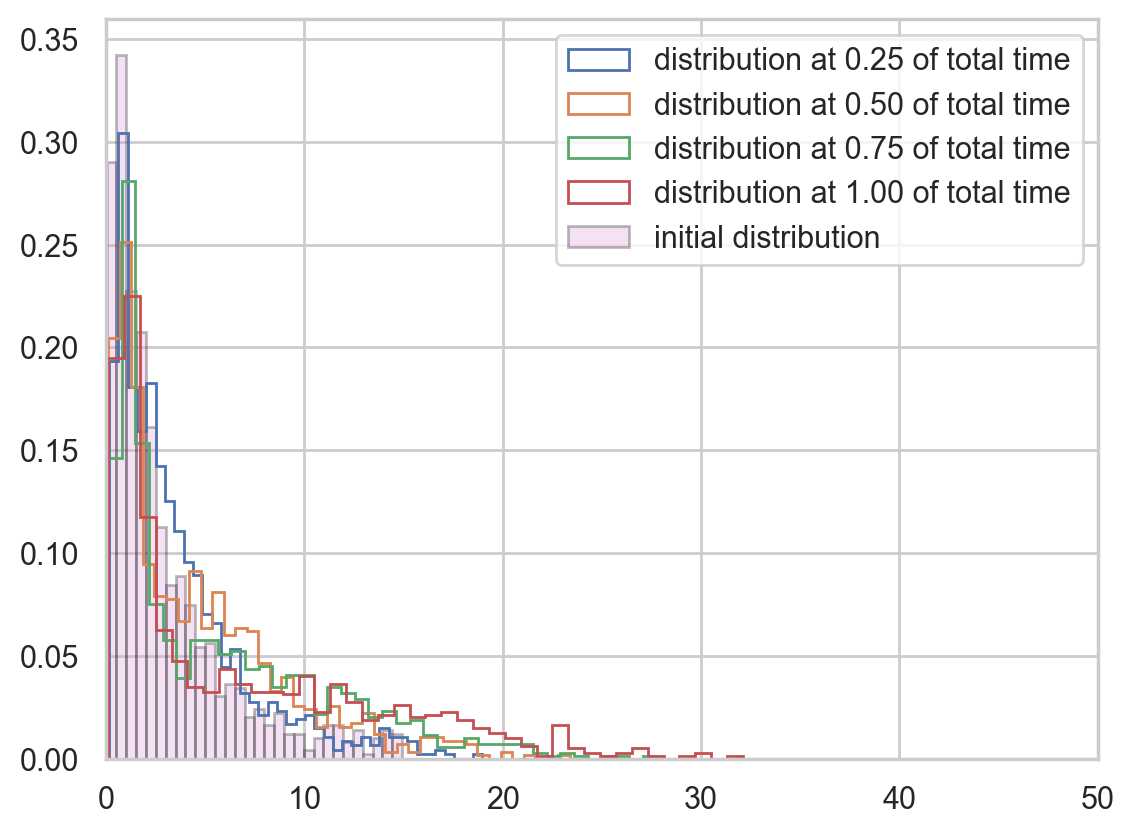

In [65]:
def distribution(frac):
    t = int(len(t_s)*frac)
    r_t = r_s[:,t-1]
    plt.hist(r_t[r_t<50], bins=40, density=True, histtype='step', label='distribution at %.2f of total time' %frac)

    
f=[0.25,0.5,0.75,1] #vectors of fractions
for frac in f:
    distribution(frac)
    
plt.hist(radii[radii<50], bins=30, density=True, alpha=0.3, color='plum', ec='k', histtype='bar', label='initial distribution');
plt.xlim(0,50)
plt.legend();

# CoM

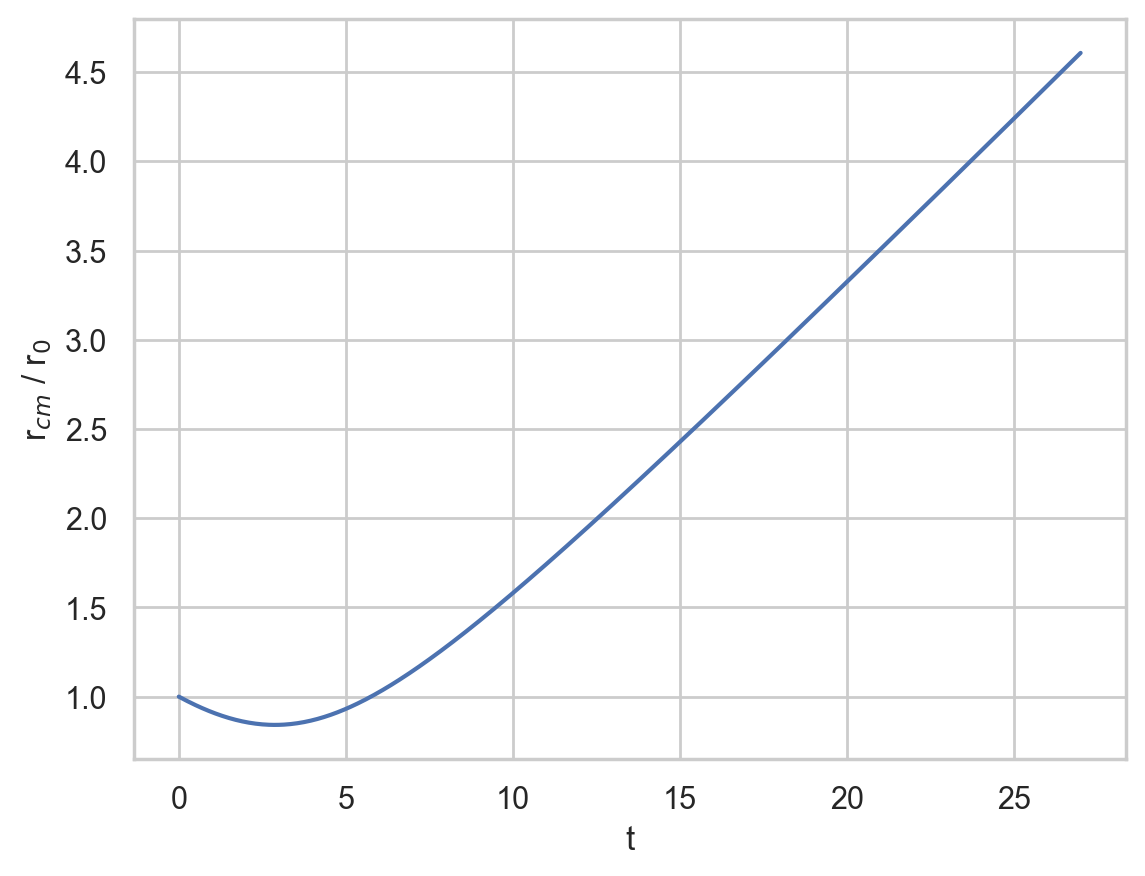

In [66]:
mu = m / M

x_cm = mu * np.sum(x_s, axis = 0)
y_cm = mu * np.sum(y_s, axis = 0)
z_cm = mu * np.sum(z_s, axis = 0)
r_cm = np.sqrt(x_cm**2 + y_cm**2 + z_cm**2)

plt.plot(t_s, r_cm/r_cm[0])
plt.ylabel('r$_{cm}$ / r$_{0}$')
plt.xlabel('t');

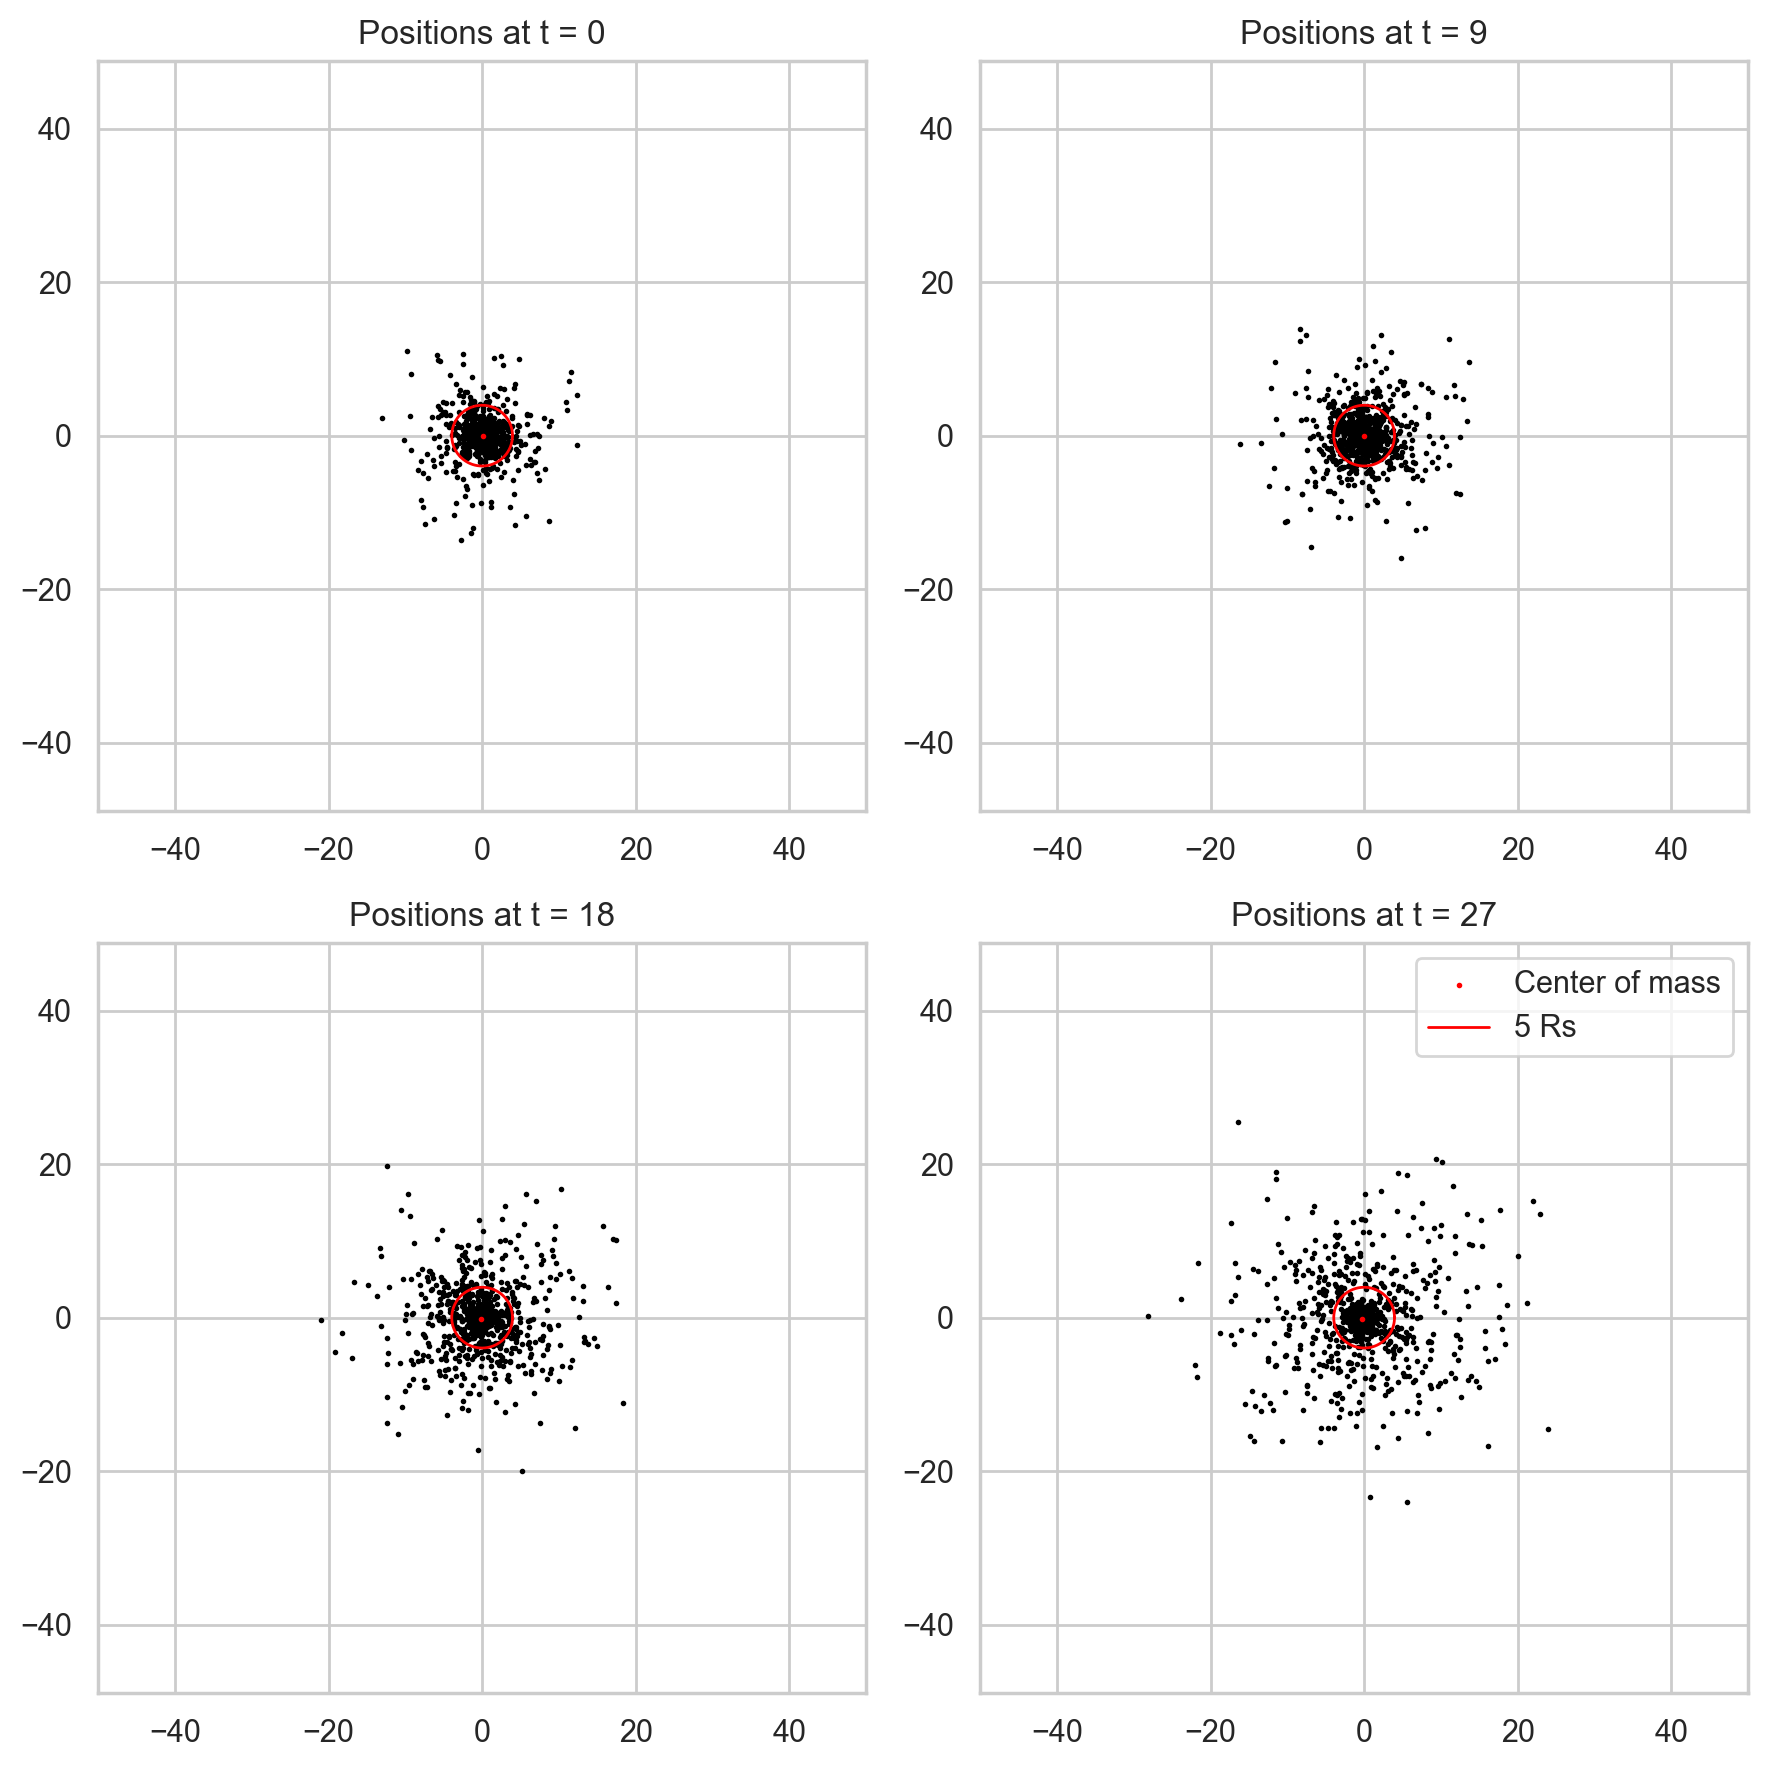

In [67]:
t0 = 0
t1 = int(np.round(len(t_s) * 1 / 3))
t2 = int(np.round(len(t_s) * 2 / 3))
t3 = -1

# Set Seaborn style
sns.set(style="whitegrid")

fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(9, 9)) 

# Plot 1
ax[0][0].scatter(x_s[:, t0], y_s[:, t0], c='black', alpha=1, s=1)#, label='Particles at t=0')

ax[0][0].scatter(x_cm[t0], y_cm[t0], c='red', alpha=1, s=1)#, label='Particles at t=0')

ax[0][0].set_title(f'Positions at t = {int(np.round(t_s[t0]))}')
ax[0][0].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[0][0].axis('equal')
#ax[0][0].legend(fontsize='large')
ax[0][0].set_xlim(-50, 50)
ax[0][0].set_ylim(-50, 50)


# Plot 2
ax[0][1].scatter(x_s[:, t1], y_s[:, t1], c='black', alpha=1, s=1)#, label='Particles at t1')
ax[0][1].scatter(x_cm[t1], y_cm[t1], c='red', alpha=1, s=1)#, label='Particles at t=0')


ax[0][1].set_title(f'Positions at t = {int(np.round(t_s[t1]))}')
ax[0][1].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[0][1].axis('equal')
#ax[0][1].legend(fontsize='large')
ax[0][1].set_xlim(-50, 50)
ax[0][1].set_ylim(-50, 50)


# Plot 3
ax[1][0].scatter(x_s[:, t2], y_s[:, t2], c='black', alpha=1, s=1)#, label='Particles at t2')
ax[1][0].scatter(x_cm[t2], y_cm[t2], c='red', alpha=1, s=1)#, label='Particles at t=0')

ax[1][0].set_title(f'Positions at t = {int(np.round(t_s[t2]))}')
ax[1][0].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[1][0].axis('equal')
#ax[1][0].legend(fontsize='large')
ax[1][0].set_xlim(-50, 50)
ax[1][0].set_ylim(-50, 50)

# Plot 4
ax[1][1].scatter(x_s[:, t3], y_s[:, t3], color='black', alpha=1, s=1)#, label='Particles at t=T_sim')
ax[1][1].scatter(x_cm[t3], y_cm[t3], c='red', alpha=1, s=1, label='Center of mass')

ax[1][1].plot(a, c, c='red', linewidth=1, label=r'5 Rs')
ax[1][1].set_title(f'Positions at t = {int(np.round(t_s[t3]))}')
ax[1][1].axis('equal')
ax[1][1].legend()
ax[1][1].set_xlim(-50, 50)
ax[1][1].set_ylim(-50, 50)

plt.show()

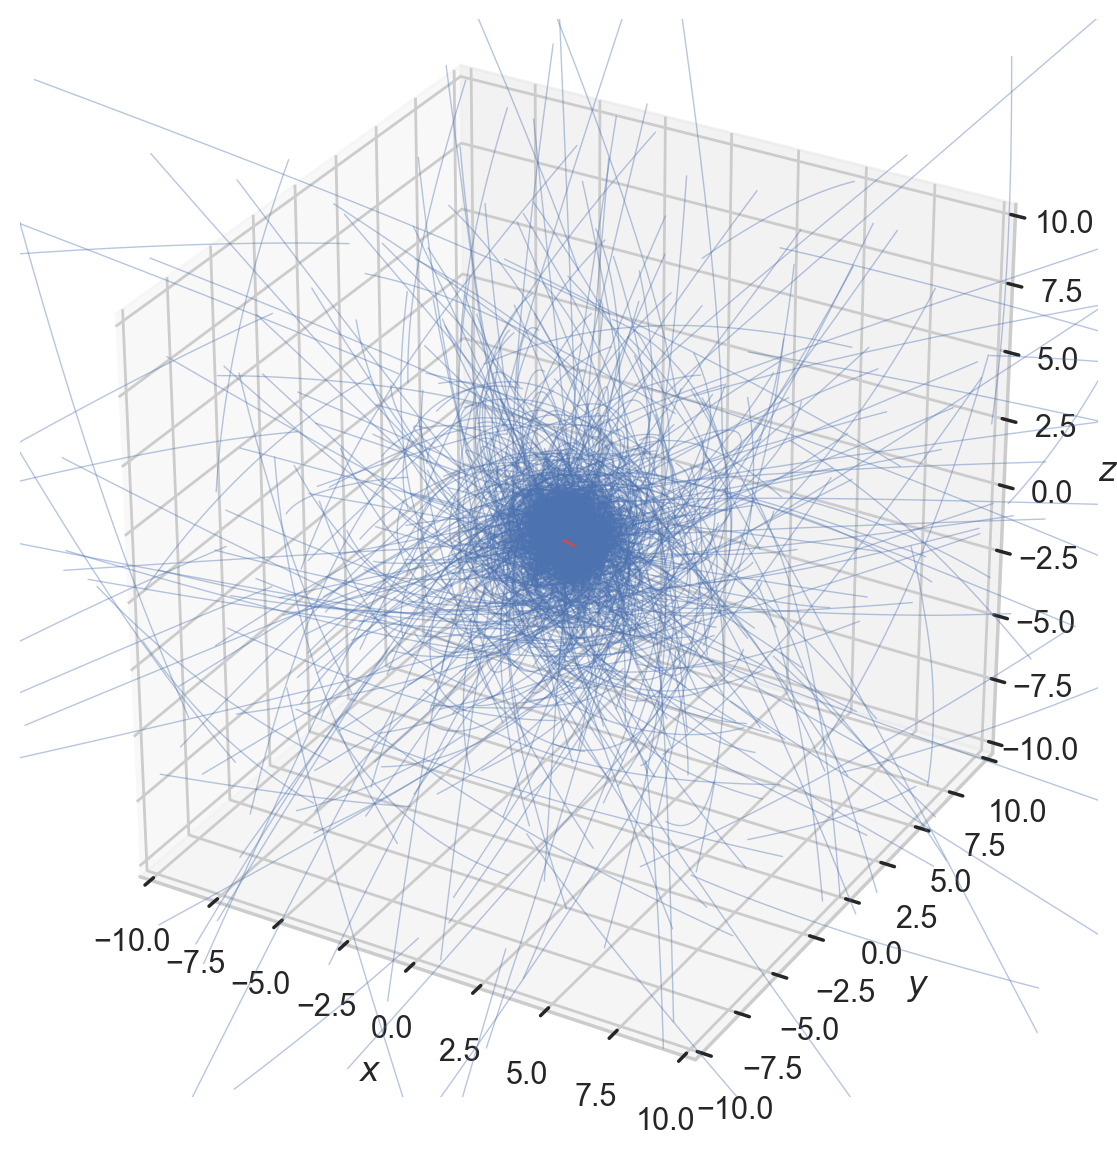

In [68]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(projection='3d')

ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)

for i in range(N):
    ax.plot(x_s[i, :], y_s[i, :], z_s[i, :], c='b', alpha=0.4, linewidth=0.5)
ax.plot(x_cm, y_cm, z_cm, c = 'r', linewidth=1)#, s=1)
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
plt.show();